# Generating Text with an RNN

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
import os
os.chdir("gdrive/My Drive/mp4")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [4]:
#!pip install torch
#!pip install unidecode

    100% |████████████████████████████████| 519.5MB 30kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x59db2000 @  0x7f056de272a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641
    100% |████████████████████████████████| 245kB 7.3MB/s 


In [35]:
import unidecode
import string
import random
import re
import time

import torch
import torch.nn as nn

%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [0]:
from rnn.model import RNN
from rnn.helpers import time_since
from rnn.generate import generate

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 

## Data Processing

The file we are using is a plain text file. We turn any potential unicode characters into plain ASCII by using the `unidecode` package (which you can install via `pip` or `conda`).

In [38]:
all_characters = string.printable
n_characters = len(all_characters)

file_path = './shakespeare.txt'
file = unidecode.unidecode(open(file_path).read())
file_len = len(file)
print('file_len =', file_len)

# we will leave the last 1/10th of text as test
split = int(0.9*file_len)
train_text = file[:split]
test_text = file[split:]

print('train len: ', len(train_text))
print('test len: ', len(test_text))

file_len = 4573338
train len:  4116004
test len:  457334


In [39]:
chunk_len = 200

def random_chunk(text):
    start_index = random.randint(0, len(text) - chunk_len)
    end_index = start_index + chunk_len + 1
    return text[start_index:end_index]

print(random_chunk(train_text))

ly?

VERNON:
So do we.

HOTSPUR:
His is certain, ours is doubtful.

EARL OF WORCESTER:
Good cousin, be advised; stir not tonight.

VERNON:
Do not, my lord.

EARL OF DOUGLAS:
You do not counsel well:
Yo


### Input and Target data

To make training samples out of the large string of text data, we will be splitting the text into chunks.

Each chunk will be turned into a tensor, specifically a `LongTensor` (used for integer values), by looping through the characters of the string and looking up the index of each character in `all_characters`.

In [0]:
# Turn string into list of longs
def char_tensor(string):
    tensor = torch.zeros(len(string), requires_grad=True).long()
    for c in range(len(string)):
        tensor[c] = all_characters.index(string[c])
    return tensor

The following function loads a batch of input and target tensors for training. Each sample comes from a random chunk of text. A sample input will consist of all characters *except the last*, while the target wil contain all characters *following the first*. For example: if random_chunk='abc', then input='ab' and target='bc'

In [0]:
def load_random_batch(text, chunk_len, batch_size):
    input_data = torch.zeros(batch_size, chunk_len).long().to(device)
    target = torch.zeros(batch_size, chunk_len).long().to(device)
    for i in range(batch_size):
        start_index = random.randint(0, len(text) - chunk_len - 1)
        end_index = start_index + chunk_len + 1
        chunk = text[start_index:end_index]
        input_data[i] = char_tensor(chunk[:-1])
        target[i] = char_tensor(chunk[1:])
    return input_data, target

# Implement model

Your RNN model will take as input the character for step $t_{-1}$ and output a prediction for the next character $t$. The model should consiste of three layers - a linear layer that encodes the input character into an embedded state, an RNN layer (which may itself have multiple layers) that operates on that embedded state and a hidden state, and a decoder layer that outputs the predicted character scores distribution.


You must implement your model in the `rnn/model.py` file. You should use a `nn.Embedding` object for the encoding layer, a RNN model like `nn.RNN` or `nn.LSTM`, and a `nn.Linear` layer for the final a predicted character score decoding layer.


**TODO:** Implement the model in RNN `rnn/model.py`

# Evaluating

To evaluate the network we will feed one character at a time, use the outputs of the network as a probability distribution for the next character, and repeat. To start generation we pass a priming string to start building up the hidden state, from which we then generate one character at a time.


Note that in the `evaluate` function, every time a prediction is made the outputs are divided by the "temperature" argument. Higher temperature values make actions more equally likely giving more "random" outputs. Lower temperature values (less than 1) high likelihood options contribute more. A temperature near 0 outputs only the most likely outputs.

You may check different temperature values yourself, but we have provided a default which should work well.

In [0]:
def evaluate(rnn, prime_str='A', predict_len=100, temperature=0.8):
    hidden = rnn.init_hidden(1, device=device)
    prime_input = char_tensor(prime_str)
    predicted = prime_str

    # Use priming string to "build up" hidden state
    for p in range(len(prime_str) - 1):
        _, hidden = rnn(prime_input[p].unsqueeze(0).to(device), hidden)
    inp = prime_input[-1]
    
    for p in range(predict_len):
        output, hidden = rnn(inp.unsqueeze(0).to(device), hidden)
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        
        # Add predicted character to string and use as next input
        predicted_char = all_characters[top_i]
        predicted += predicted_char
        inp = char_tensor(predicted_char)

    return predicted

# Train RNN

In [0]:
batch_size = 100
n_epochs = 2000
hidden_size = 150
n_layers = 2
learning_rate = 0.001
model_type = 'gru'
print_every = 50
plot_every = 50


In [0]:
def eval_test(rnn, inp, target):
    with torch.no_grad():
        hidden = rnn.init_hidden(batch_size, device=device)
        loss = 0
        for c in range(chunk_len):
            output, hidden = rnn(inp[:,c], hidden)
            loss += criterion(output.view(batch_size, -1), target[:,c])
    
    return loss.data.item() / chunk_len

### Train function

**TODO**: Fill in the train function. You should initialize a hidden layer representation using your RNN's `init_hidden` function, set the model gradients to zero, and loop over each time step (character) in the input tensor. For each time step compute the output of the of the RNN and compute the loss over the output and the corresponding ground truth time step in `target`. The loss should be averaged over all time steps. Lastly, call backward on the averaged loss and take an optimizer step.


In [0]:
def train(rnn, _input, target, optimizer, criterion):
    """
    Inputs:
    - rnn: model
    - input: input character data tensor of shape (batch_size, chunk_len)
    - target: target character data tensor of shape (batch_size, chunk_len)
    - optimizer: rnn model optimizer
    - criterion: loss function
    
    Returns:
    - loss: computed loss value as python float
    """
    
    ####################################
    #          YOUR CODE HERE          #
    ####################################
    loss = 0
    hidden = rnn.init_hidden(batch_size, device=device)
    rnn.zero_grad()

    for c in range(chunk_len):
        output, hidden = rnn(_input[:,c], hidden)
        loss += criterion(output, target[:,c])

    loss /= chunk_len
    
    loss.backward()
    optimizer.step()

    #loss = loss.data[0] / chunk_len #####should be loss.data.item()?
    
    ##########       END      ##########

    return loss


In [46]:
rnn = RNN(n_characters, hidden_size, n_characters, model_type=model_type, n_layers=n_layers).to(device)
rnn_optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
test_losses = []
loss_avg = 0
test_loss_avg = 0


print("Training for %d epochs..." % n_epochs)
for epoch in range(1, n_epochs + 1):
    loss = train(rnn, *load_random_batch(train_text, chunk_len, batch_size), rnn_optimizer, criterion)
    loss_avg += loss
    
    test_loss = eval_test(rnn, *load_random_batch(test_text, chunk_len, batch_size))
    test_loss_avg += test_loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) train loss: %.4f, test_loss: %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss, test_loss))
        print(generate(rnn, 'Wh', 100, device=device), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        test_losses.append(test_loss_avg / plot_every)
        loss_avg = 0
        test_loss_avg = 0

Training for 2000 epochs...
 28s (50 2%) train loss: 2.7492, test_loss: 2.7497]
Wher aus gaircih-Klt yr t,

HRSA!_Bhte ate ehe, phet irh thm thw bme ainss hey t thome, su yo oll t ue 

 56s (100 5%) train loss: 2.2808, test_loss: 2.2928]
Wh, ouptat olme konthry the wpwin hor th the the an! mat aoor and bass fhand ad to at fone fill wa muc 

 24s (150 7%) train loss: 2.1200, test_loss: 2.1126]
Whith yoursen the king beif I do whal: and distis neralus?

YORL:
Mutiy besthe the thes, chas groness  

 52s (200 10%) train loss: 1.9840, test_loss: 1.9969]
Whe, the wery flangering this vanibnement there hite sectese at in fair, Hid we suse feat:
And the rei 

 20s (250 12%) train loss: 1.8851, test_loss: 1.8847]
Why lacket, some not the sey
God afrent in the too?

PARDLUS:
I did lovers, whlomoul and here, dear of 

 49s (300 15%) train loss: 1.8157, test_loss: 1.8281]
Why powes ead-there: so thy the mess that serve upon:
The do;
As are our are so corver am this all sco 

 17s (350 17%) train l

In [0]:
# save network
# torch.save(classifier.state_dict(), './rnn_generator.pth')

# Plot the Training and Test Losses

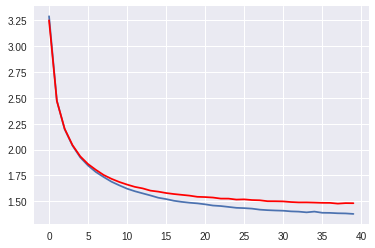

In [48]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)
plt.plot(test_losses, color='r')

# Evaluate text generation

Check what the outputted text looks like

In [49]:
print(evaluate(rnn, prime_str='Th', predict_len=1000))

This naught her to the sleep!
That shall been you thou yet to
At the other to me, and to the duke to advances
Marry be as much down.

ROSSALINE:
Ay, then I have room in a short, that a times.

LYCAILUS:
Full the cousin, being father in a words,
The deed strings the serve with the company, see.
Lord knee quarters in the properor and kind on my love
That thus on her understand to comforth becomes
to caintly have benefites shall be gone.

POLPEY:
O gain you sad to send upon all amends.

PANEROLLES:
Let him out of me so unpressips, we debered.

DUKE SYRACUSE:
If you shall be conceit his daughter in
By help it. This is the godges of my wise;
What are strength, here we stand understand this
word off my slain! Can the thilk not twasty.

DON PEDRO:
Then blush and here on dog;
For I, his wish'd, smoke the gods, my lords!
How now, sir, and through that a farther, as the king
That he lost like a devil, nor away,
And let their father;' yet so besting that that
sweer at much many consicial bring li

# Hyperparameter Tuning

Some things you should try to improve your network performance are:
- Different RNN types. Switch the basic RNN network in your model to a GRU and LSTM to compare all three.
- Try adding 1 or two more layers
- Increase the hidden layer size
- Changing the learning rate

**TODO:** Try changing the RNN type and hyperparameters. Record your results.